In [87]:
%load_ext autoreload
%autoreload 2

import os
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from copy import deepcopy
import h5py
mpl.style.use('style.mcstyle')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
from cmass.infer.loaders import get_cosmo
from cmass.utils import cosmo_to_astropy

wdir = '/anvil/scratch/x-mho1/cmass-ili'

## Load and plot MTNG data

In [77]:
nbody = 'mtng'
sim = 'nbody'
L, N = 3000, 384
lhid = 0
simpath = join(wdir, f'{nbody}/{sim}/L{L}-N{N}/{lhid}/')

cosmo = get_cosmo(simpath)
cosmo = cosmo_to_astropy(cosmo)

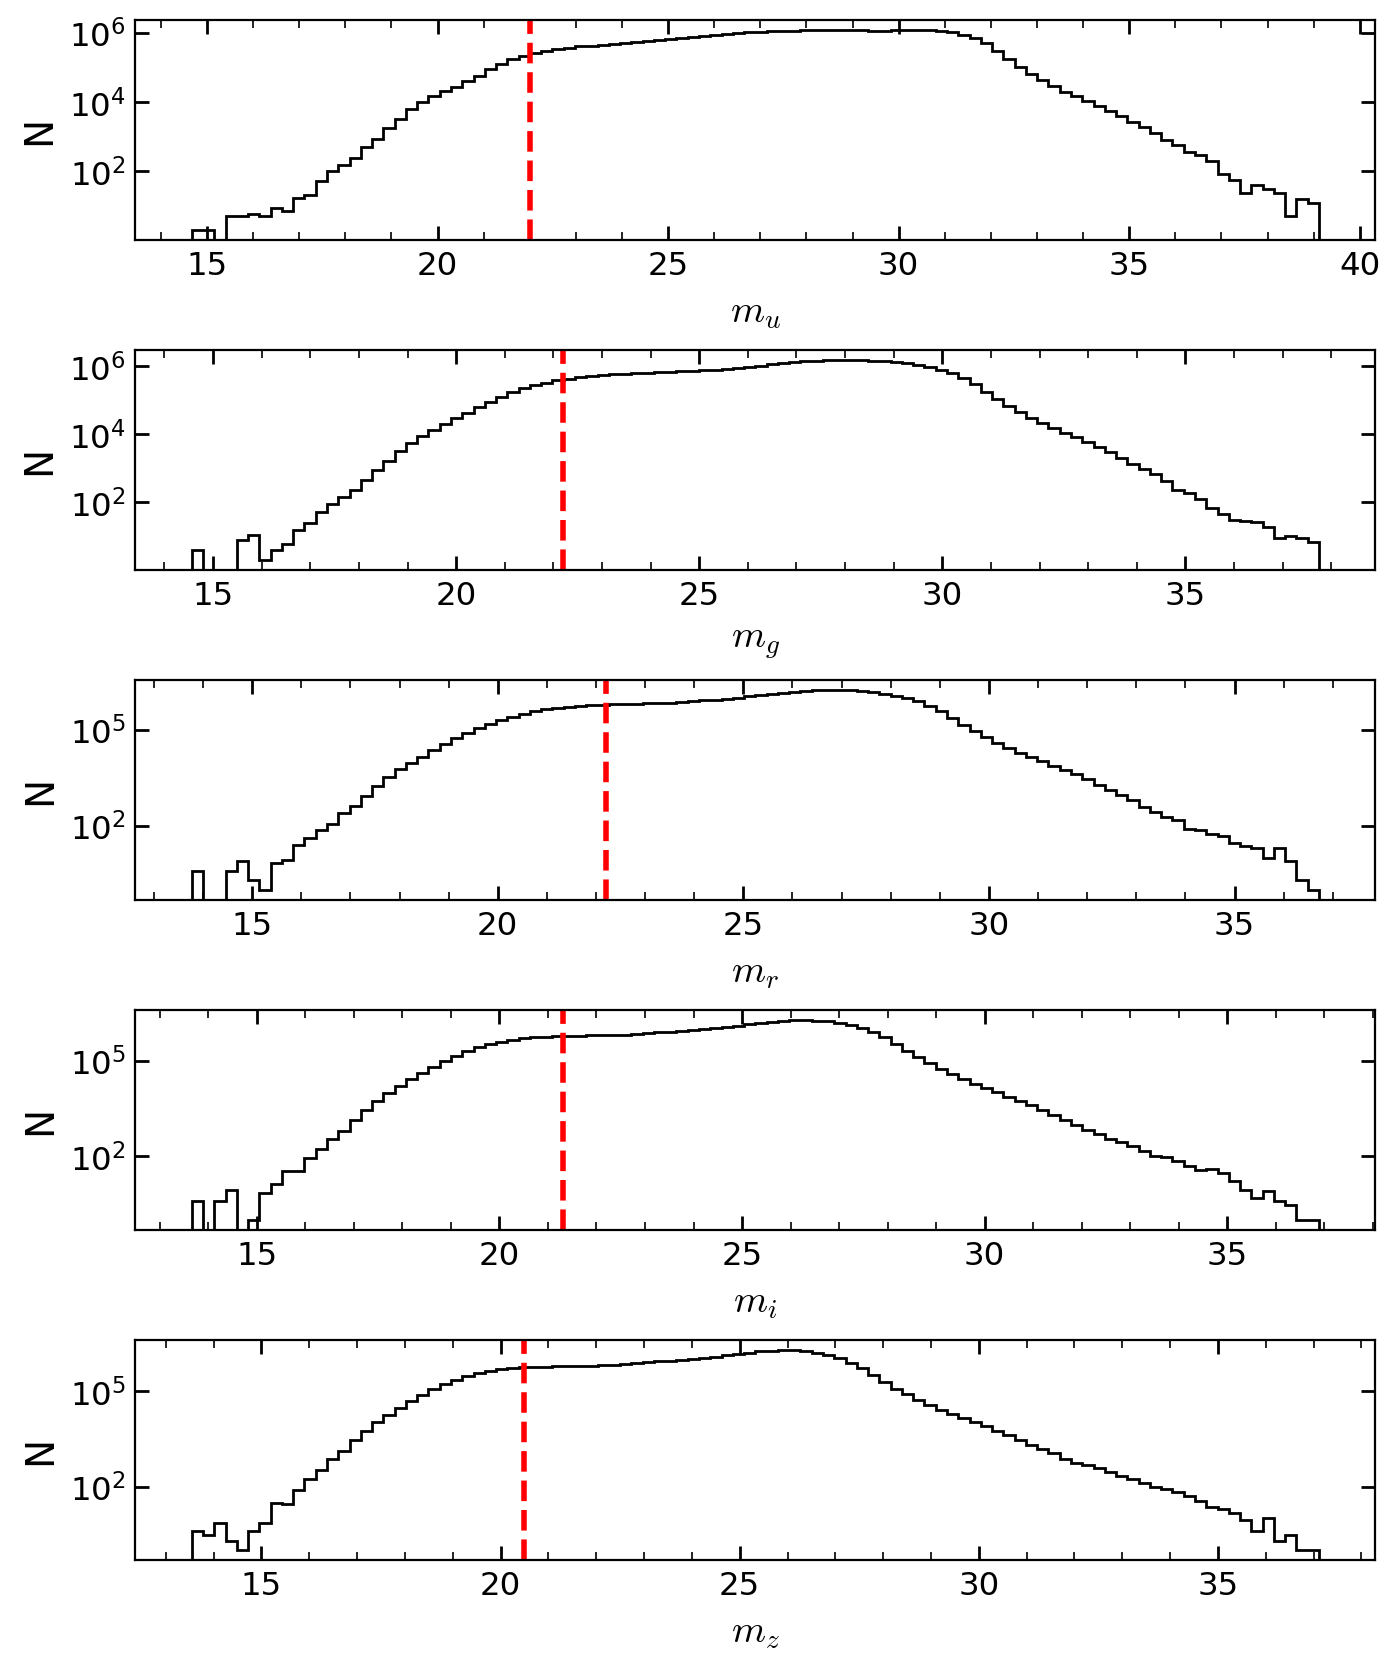

In [78]:
gmagobs = np.load(join(simpath, 'galaxy_obsmag.npy'))  # NOTE: without dust!
bands = ['u', 'g', 'r', 'i', 'z']
bandlim = [22, 22.2, 22.2, 21.3, 20.5]
# bandlim = [22]

N = gmagobs.shape[-1]
f, axs = plt.subplots(N, 1, figsize=(8, 2*N),
                      gridspec_kw={'hspace': 0.5})
for i in range(N):
    axs[i].hist(gmagobs[:, i], bins=100, histtype='step', color='k')
    axs[i].axvline(bandlim[i], color='r', ls='--')
    axs[i].set_xlabel(f'$m_{bands[i]}$')
    axs[i].set_ylabel('N')
    axs[i].set_yscale('log')

In [79]:
# Load halo data
hpos = np.load(join(simpath, 'halo_pos.npy'))
hvel = np.load(join(simpath, 'halo_vel.npy'))
hmass = np.load(join(simpath, 'halo_mass.npy'))
hsmass = np.load(join(simpath, 'galaxy_stellarmass.npy'))
hid = np.arange(len(hpos), dtype=int)

mask = np.ones(len(hpos), dtype=bool)
for i in range(len(bandlim)):
    mask = mask & (gmagobs[:, i] <= bandlim[i])
print(f'Original: {len(hpos)}, Masked: {mask.sum()}')

hpos = hpos[mask]
hvel = hvel[mask]
hmass = hmass[mask]
hsmass = hsmass[mask]
hid = hid[mask]

Original: 37265829, Masked: 794833


In [80]:
# Convert to ra, dec, z

from cmass.survey.tools import xyz_to_sky
rdz = xyz_to_sky(hpos, hvel, cosmo)

mask = (rdz[:, 2] > 0.4) & (rdz[:, 2] < 0.7)
print(f'Original: {len(hpos)}, Masked: {mask.sum()}')

hpos = hpos[mask]
hvel = hvel[mask]
hmass = hmass[mask]
hsmass = hsmass[mask]
hid = hid[mask]
rdz = rdz[mask]

Original: 794833, Masked: 790149


In [81]:
# measure and save the n(z)
outfile = join(wdir, 'obs', 'n-z_MTNG.npy')
h, be = np.histogram(rdz[:, 2], bins=100, range=(0.4, 0.7))
np.save(outfile, dict(h=h, be=be))

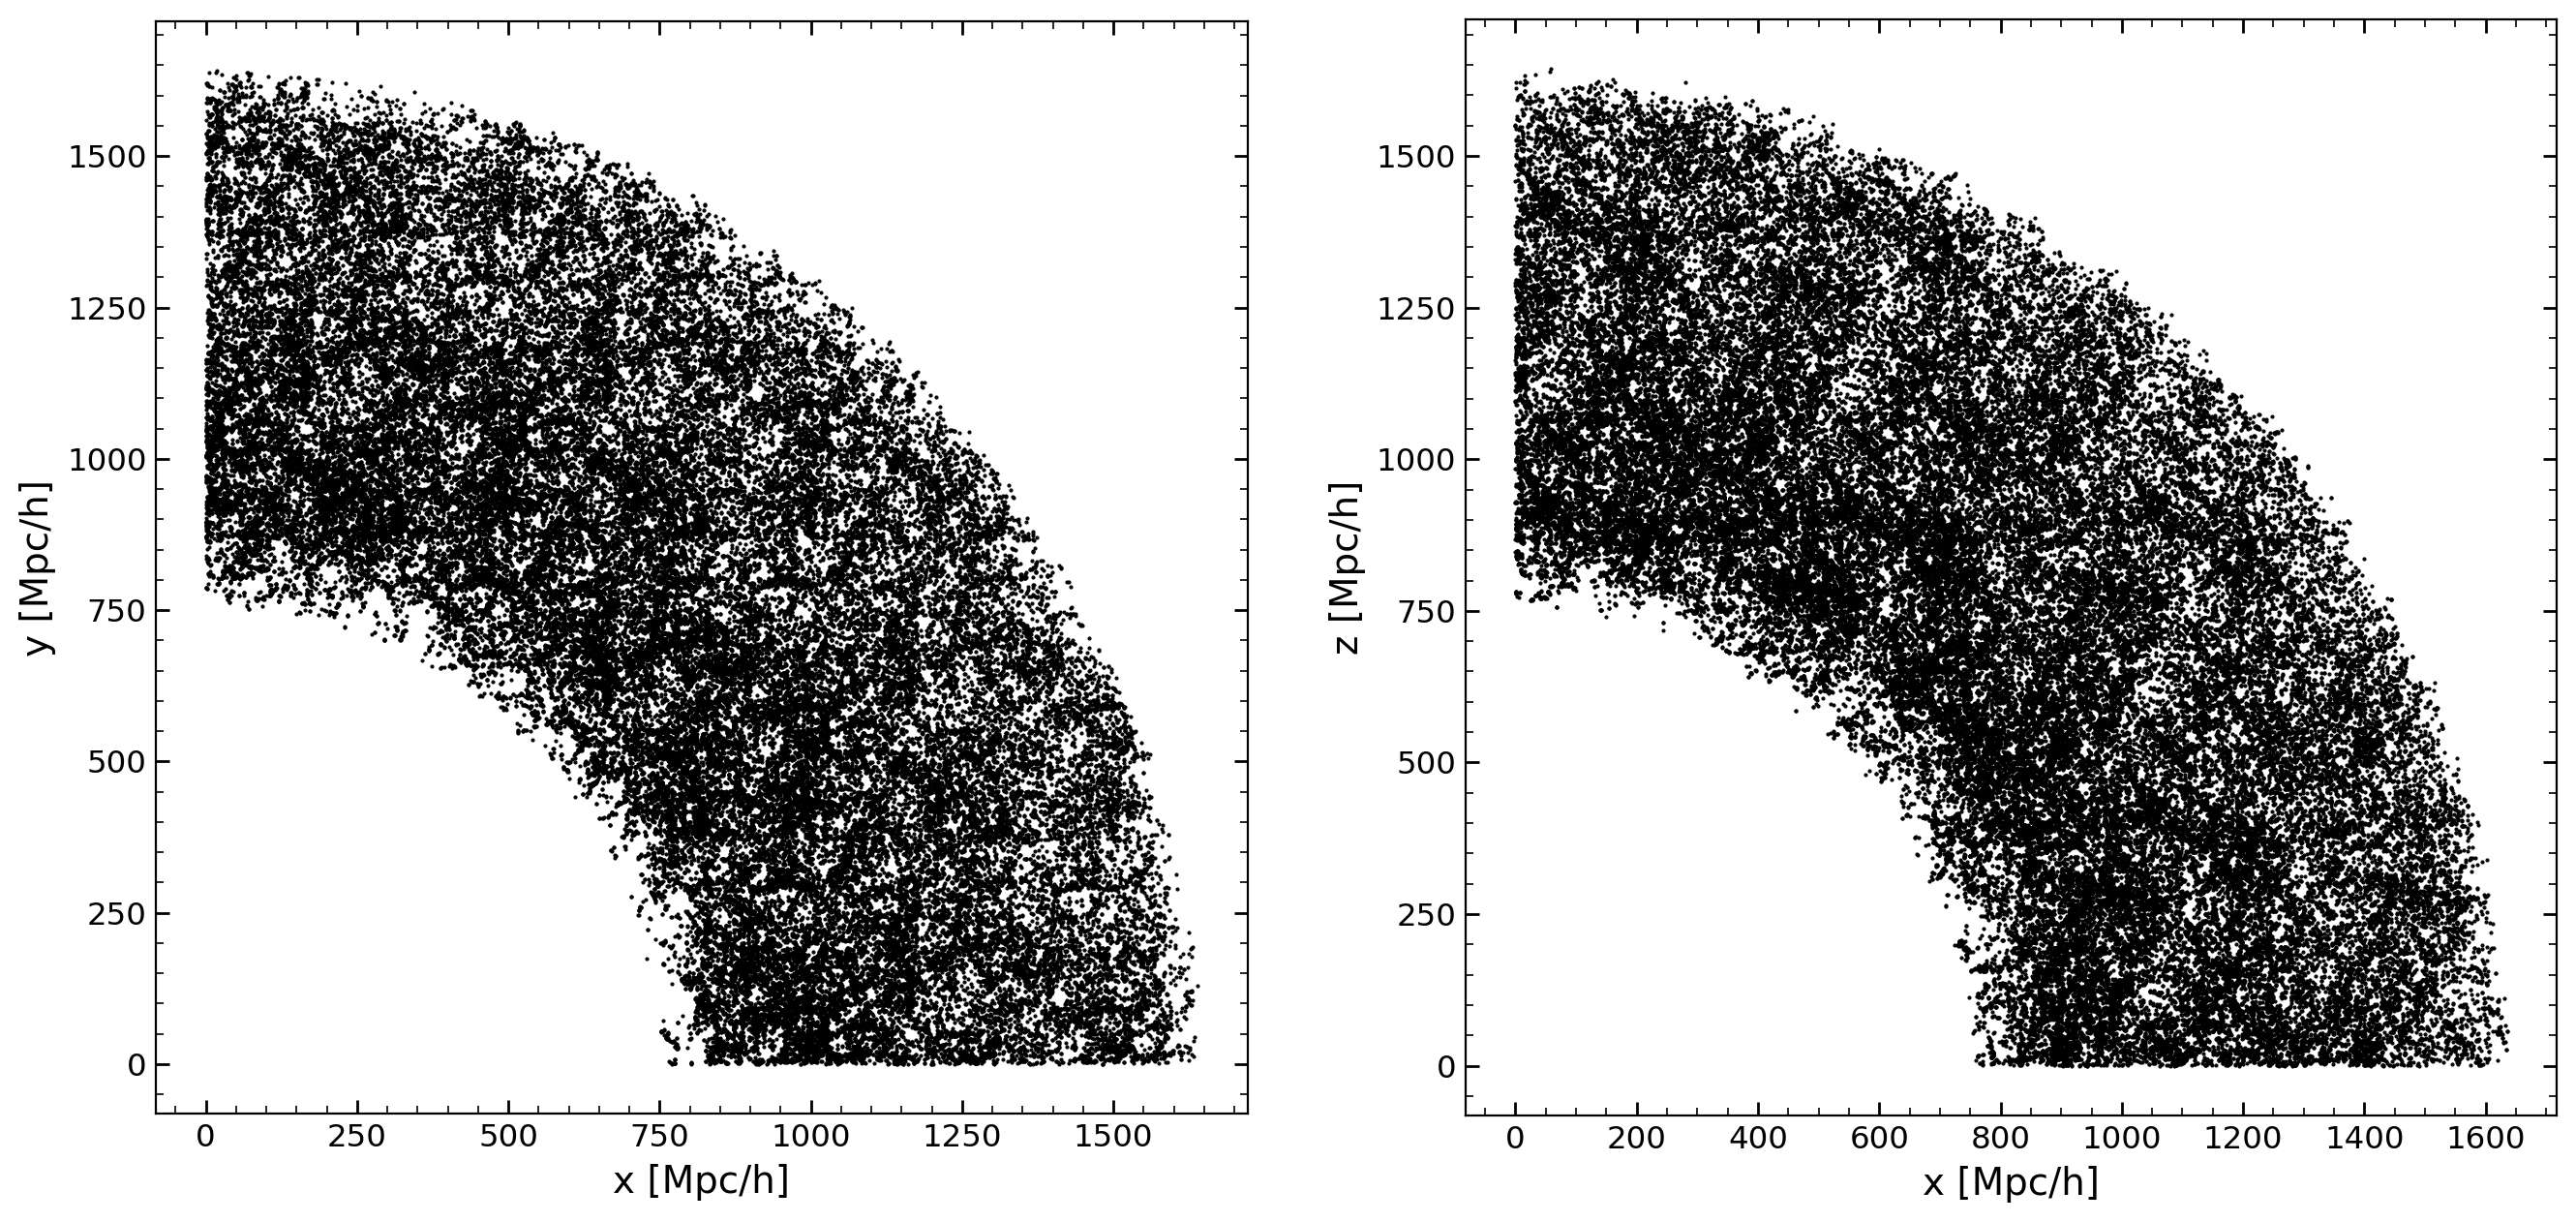

In [82]:
def plot_slice(x, y, z, w, ax, **kwargs):
    mask = np.abs(z - np.median(z)) < w
    ax.plot(x[mask], y[mask], **kwargs)


f, axs = plt.subplots(1, 2, figsize=(16, 8))
ax = axs[0]
plot_slice(*hpos.T, 100, ax, c='k', ls='', marker='.', ms=1)
ax.set(xlabel='x [Mpc/h]', ylabel='y [Mpc/h]')
ax.set_aspect('equal')

ax = axs[1]
plot_slice(hpos[:, 1], hpos[:, 2], hpos[:, 0],
           100, ax, c='k', ls='', marker='.', ms=1)
ax.set(xlabel='x [Mpc/h]', ylabel='z [Mpc/h]')
ax.set_aspect('equal')

[Text(0.5, 0, 'Redshift z'), Text(0, 0.5, 'N')]

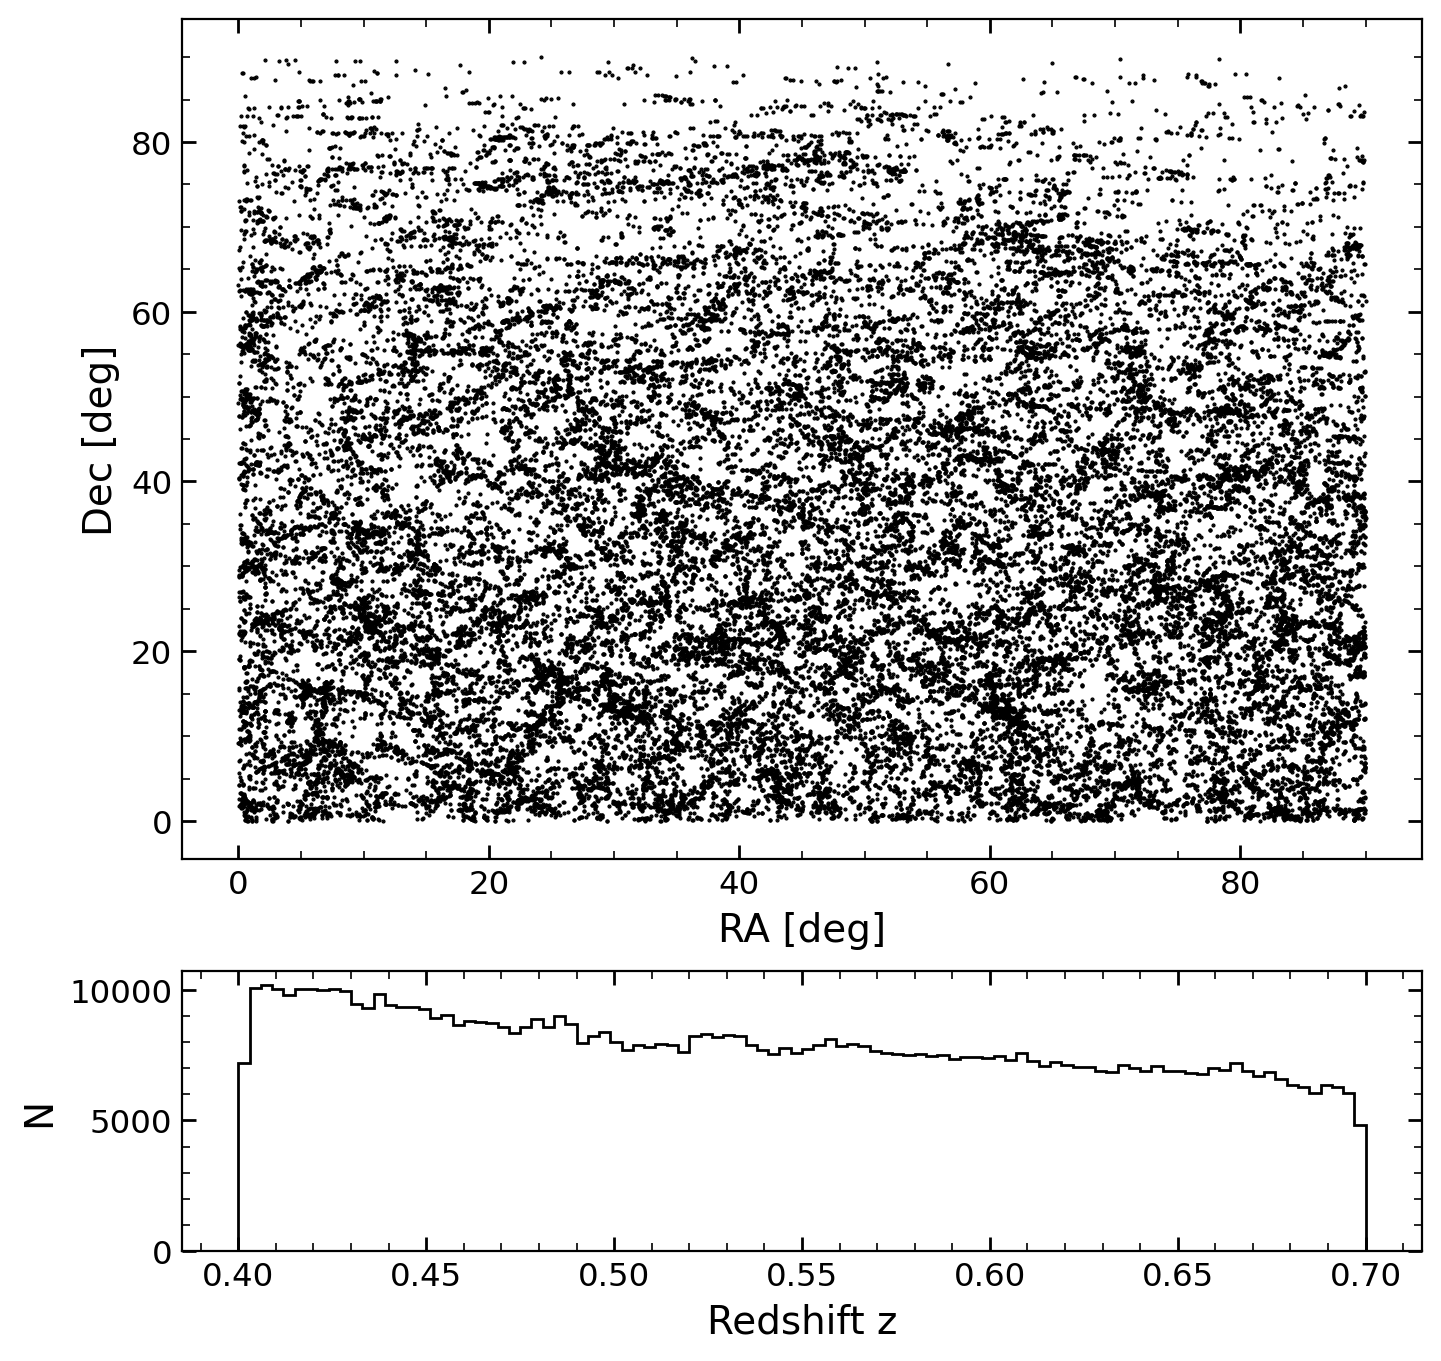

In [83]:
f, axs = plt.subplots(
    2, 1, figsize=(8, 8),
    gridspec_kw=dict(height_ratios=[3, 1]))
ax = axs[0]
plot_slice(*rdz.T, 0.01, ax, c='k', ls='', marker='.', ms=1)
ax.set(xlabel='RA [deg]', ylabel='Dec [deg]')

ax = axs[1]
ax.hist(rdz[:, 2], bins=100, histtype='step', color='k')
ax.set(xlabel='Redshift z', ylabel='N')

In [84]:
# let's save this to file
from cmass.survey.tools import save_lightcone

outdir = join(simpath, 'mtng_lightcone')
os.makedirs(outdir, exist_ok=True)
save_lightcone(
    outdir,
    ra=rdz[:, 0], dec=rdz[:, 1], z=rdz[:, 2],
    galsnap=np.zeros(len(rdz), dtype=int),
    galidx=np.arange(len(rdz)),
    hod_seed=0,
    aug_seed=0)

## Now let's compare to our sims

In [86]:
nbody = 'mtnglike'
sim = 'fastpm'
L, N = 3000, 384
lhid = 1
simpath = join(wdir, f'{nbody}/{sim}/L{L}-N{N}/{lhid}/')

cosmo = get_cosmo(simpath)
cosmo = cosmo_to_astropy(cosmo)

In [91]:
hod = 11
filename = join(simpath, 'mtng_lightcone', f'hod{hod:05}_aug{0:05}.h5')

with h5py.File(filename, 'r') as f:
    ra = f['ra'][:]
    dec = f['dec'][:]
    z = f['z'][:]
rdz = np.vstack([ra, dec, z]).T

[Text(0.5, 0, 'Redshift z'), Text(0, 0.5, 'N')]

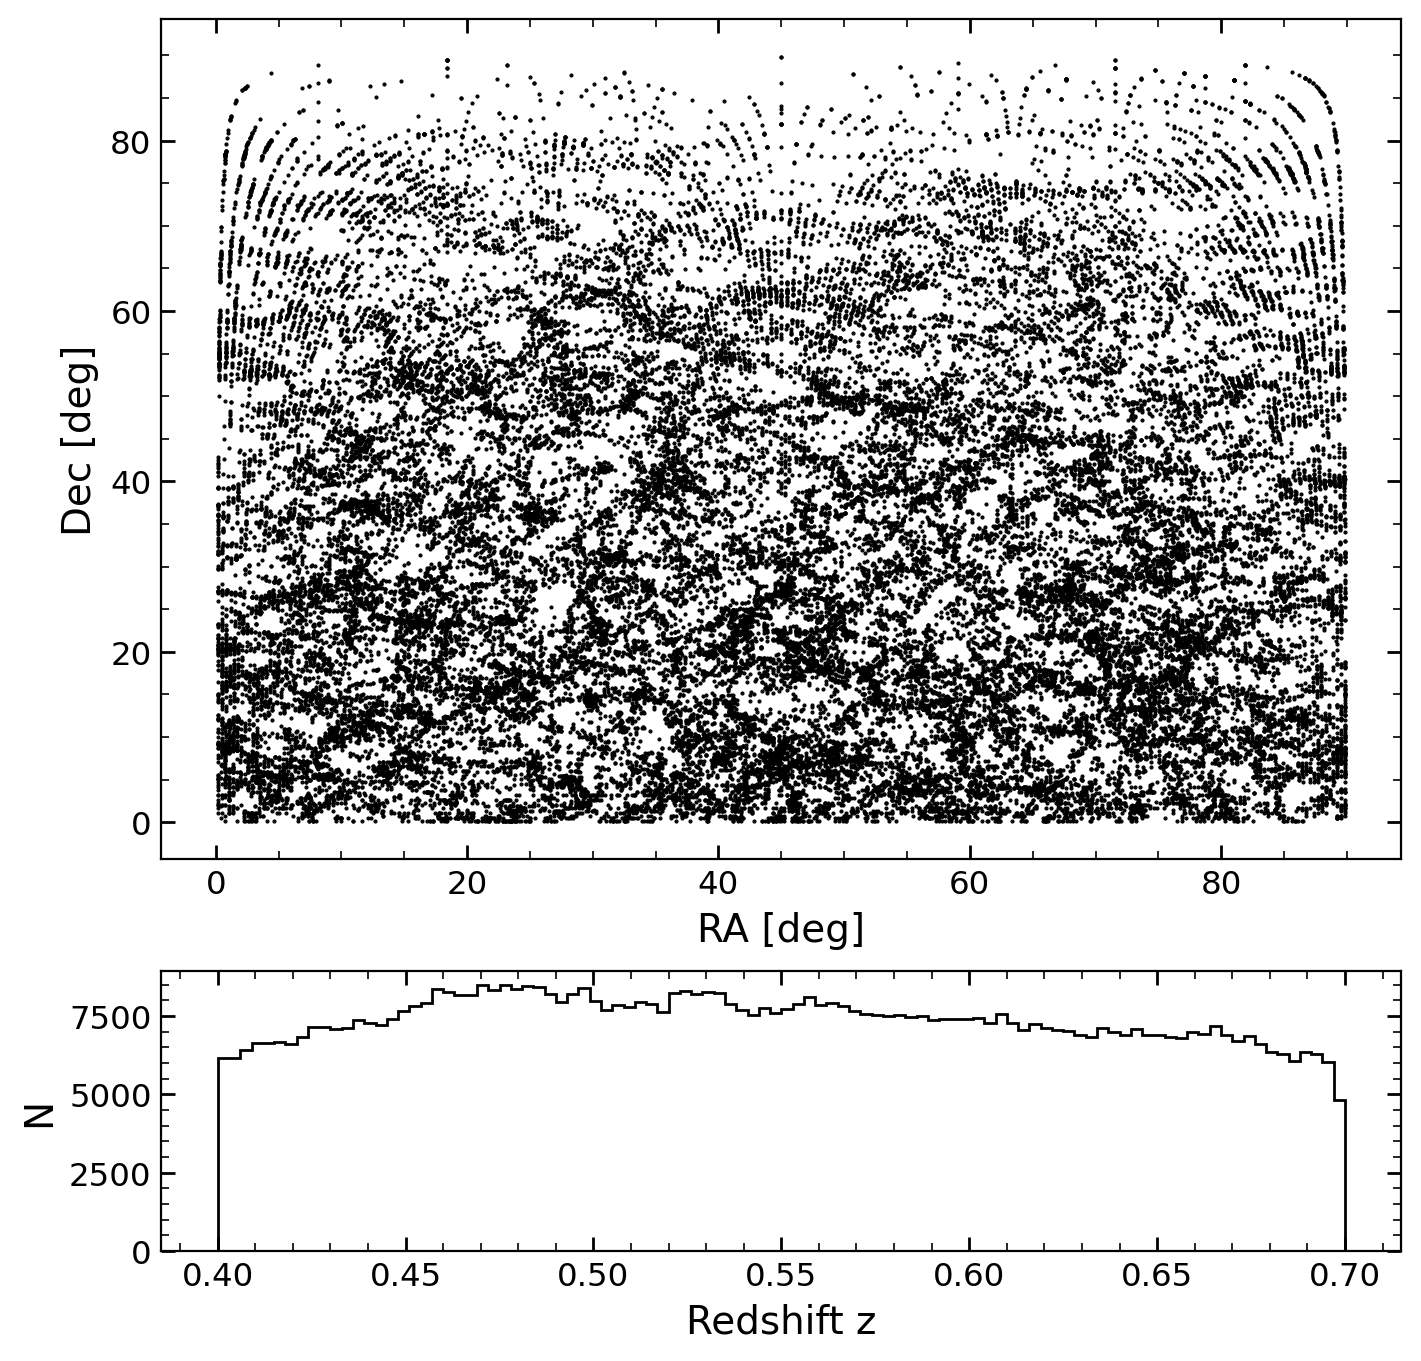

In [92]:
f, axs = plt.subplots(
    2, 1, figsize=(8, 8),
    gridspec_kw=dict(height_ratios=[3, 1]))
ax = axs[0]
plot_slice(*rdz.T, 0.01, ax, c='k', ls='', marker='.', ms=1)
ax.set(xlabel='RA [deg]', ylabel='Dec [deg]')

ax = axs[1]
ax.hist(rdz[:, 2], bins=100, histtype='step', color='k')
ax.set(xlabel='Redshift z', ylabel='N')

In [93]:
hod = 11
filename = join(simpath, 'diag', 'mtng_lightcone', f'hod{hod:05}_aug{0:05}.h5')

with h5py.File(filename, 'r') as f:
    k = f['Pk_k3D'][:]
    Pk = f['Pk'][:]

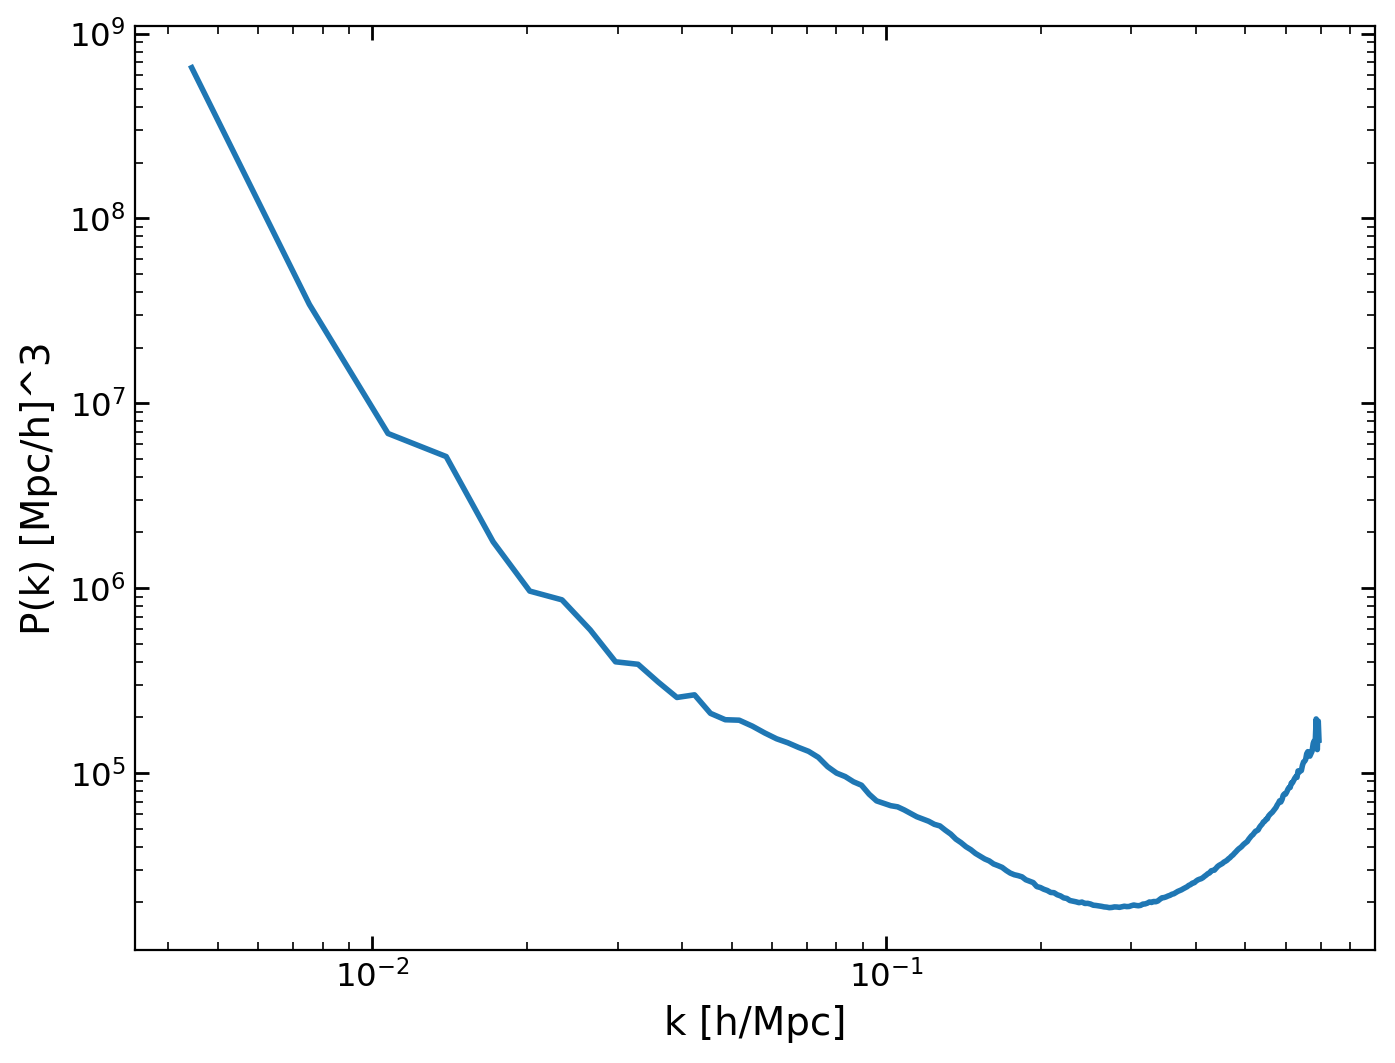

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.loglog(k, Pk[:, 0])
ax.set(xlabel='k [h/Mpc]', ylabel='P(k) [Mpc/h]^3')